# Question 6
With reference to the InsideAirbnb data (i.e. using numbers, figures, maps, and descriptive statistics), what does an analysis of Hosts and the types of properties that they list suggest about the nature of Airbnb lettings in London? To do for final: Add descriptions to each map. 

In [42]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

In [44]:
##--Airbnb Data--##

airbnb = pd.read_csv("data/20240614-London-listings.csv.gz")

airbnb = gpd.GeoDataFrame(airbnb, 
                       geometry=gpd.points_from_xy(airbnb.longitude, airbnb.latitude), 
                       crs="EPSG:4326").to_crs(epsg=27700)

airbnb.head(2)

,id,listing_url,last_scraped,name,description,host_id,host_name,host_since,host_location,host_is_superhost,...,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,reviews_per_month,geometry
0,1126718007114818432,https://www.airbnb.com/rooms/1126718007114818431,2024-06-14,Cozy house in Northolt,Located 1 minute away from a bus stop and 10 m...,380326752,Sadikshya,2020-12-15,NaN,False,...,48.0,3,365,269,0,NaN,NaN,NaN,NaN,POINT (511488.009 183013.814)
1,702589406864297984,https://www.airbnb.com/rooms/702589406864297985,2024-06-15,Up in the sky in London!,"One bedroom with double bed, desk and with th...",77760754,Lena,2016-06-14,"London, United Kingdom",True,...,42.0,1,365,146,83,2023-08-30,2024-06-13,4.94,8.56,POINT (536180.695 185752.726)


In [45]:
#London Ward Profiles 
##--London Ward Profiles--##

ward_profiles = pd.read_csv("data/ward-profiles.csv", encoding="latin1")

#including only selected variables
ward_profiles = ward_profiles[['Ward name', 'New code','Average Public Transport Accessibility score - 2014','Median House Price (£) - 2014','Median Household income estimate (2012/13)','(ID2010) - Rank of average score (within London) - 2010','(ID2010) % of LSOAs in worst 50% nationally - 2010','Average GCSE capped point scores - 2014',
    '% BAME - 2011','Number of Household spaces - 2011']]

ward_profiles.head(2)

,Ward name,New code,Average Public Transport Accessibility score - 2014,Median House Price (£) - 2014,Median Household income estimate (2012/13),(ID2010) - Rank of average score (within London) - 2010,(ID2010) % of LSOAs in worst 50% nationally - 2010,Average GCSE capped point scores - 2014,% BAME - 2011,Number of Household spaces - 2011
0,City of London,E09000001,7.9,765000.0,63620.0,551.0,20.0,354.5,21.4,5530
1,Barking and Dagenham - Abbey,E05000026,6.0,173000.0,33920.0,166.0,85.7,317.7,71.9,4753


In [46]:
#filtering data 
from datetime import datetime, timedelta

# Filter min. nights
filtered_airbnb=airbnb[airbnb.minimum_nights<=30]

## To determine recently active sites

# Convert 'last_review' to datetime format
filtered_airbnb.loc[:, 'last_review'] = pd.to_datetime(filtered_airbnb['last_review'], errors='coerce')

# Set the reference date (for reproducibility)
reference_date = datetime(2024, 11, 28)

# Calculate the threshold date (6 months before the reference date)
six_months_ago = reference_date - timedelta(days=6 * 30) 

# Filter the data
filtered_airbnb = filtered_airbnb[filtered_airbnb['last_review'] >= six_months_ago]

filtered_airbnb = filtered_airbnb[filtered_airbnb['availability_365'] >= 90]

In [19]:
##--Wards Geometry Data--##

wards = gpd.read_file("data/London-wards-2011/London_Ward_CityMerged.shp").to_crs(epsg=27700)[["GSS_CODE", "HECTARES", "geometry"]]
boroughs = gpd.read_file("London_Borough_Excluding_MHW.shp")


inner_london_boroughs = [
    'Camden', 'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Islington', 
    'Kensington and Chelsea', 'Lambeth', 'Lewisham', 'Southwark', 'Tower Hamlets', 
    'Wandsworth', 'Westminster', 'City of London'
]
inner_boroughs = boroughs[boroughs['NAME'].isin(inner_london_boroughs)]

DataSourceError: 'data/London-wards-2011/London_Ward_CityMerged.shp.xml' not recognized as being in a supported file format. It might help to specify the correct driver explicitly by prefixing the file path with '<DRIVER>:', e.g. 'CSV:path'.

                   NAME   GSS_CODE   HECTARES  NONLD_AREA ONS_INNER SUB_2009  \
0  Kingston upon Thames  E09000021   3726.117       0.000         F     None   
1               Croydon  E09000008   8649.441       0.000         F     None   
2               Bromley  E09000006  15013.487       0.000         F     None   
3              Hounslow  E09000018   5658.541      60.755         F     None   
4                Ealing  E09000009   5554.428       0.000         F     None   

  SUB_2006                                           geometry  
0     None  POLYGON ((516401.6 160201.8, 516407.3 160210.5...  
1     None  POLYGON ((535009.2 159504.7, 535005.5 159502, ...  
2     None  POLYGON ((540373.6 157530.4, 540361.2 157551.9...  
3     None  POLYGON ((521975.8 178100, 521967.7 178096.8, ...  
4     None  POLYGON ((510253.5 182881.6, 510249.9 182886, ...  


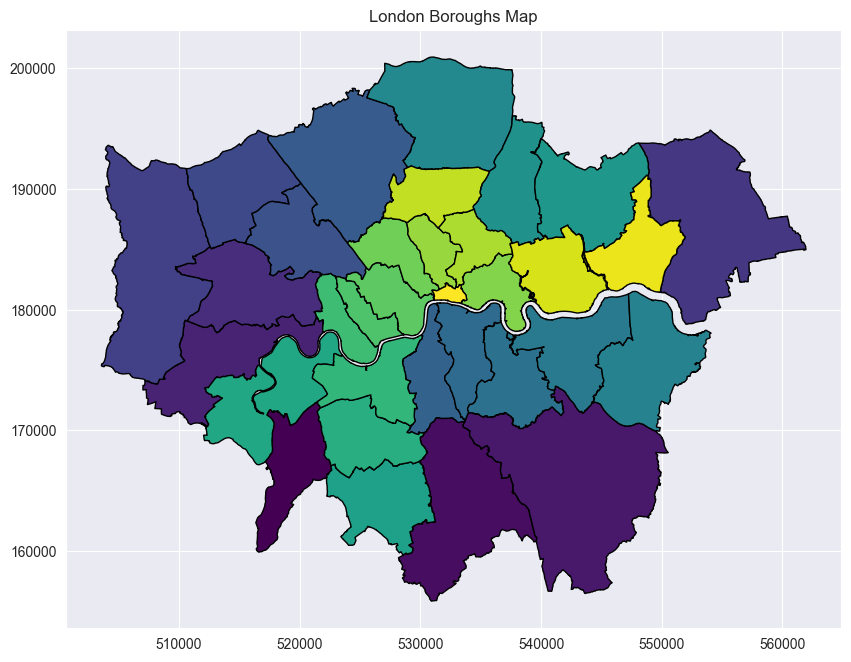

In [47]:
# London Boroughs 
# Load the GeoPackage file
file_path = "data/London_Boroughs_2011.shp"  # Update with the correct path
boroughs = gpd.read_file(file_path)

# Check the data
print(boroughs.head())

# Plot the data
boroughs.plot(figsize=(10, 10), edgecolor="black", cmap="viridis")
plt.title("London Boroughs Map")
plt.show()


# Distribution of Airbnb listings in London 
Minimum nights: 30 days
Last review: 6 months ago
Availability: 90 days
Property Type: All 

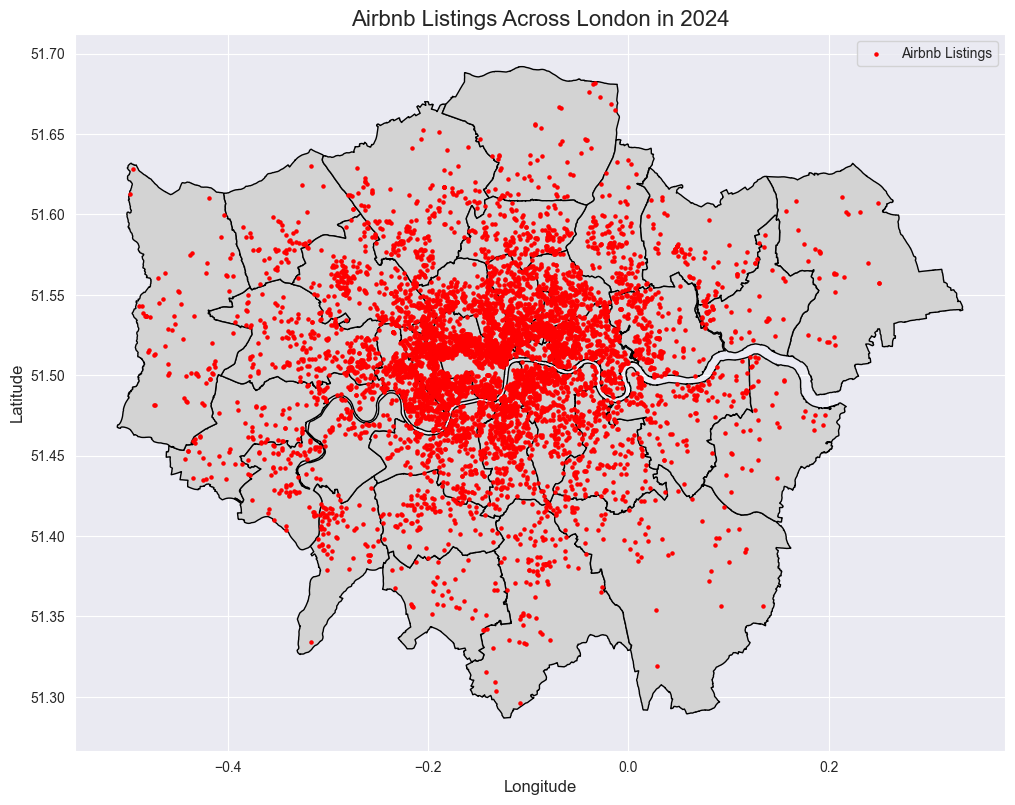

In [48]:
#Distribution of Airbnb listings 
# Ensure the boroughs have a CRS set
if boroughs.crs is None:
    boroughs.set_crs(epsg=27700, inplace=True)  # Assuming original CRS is EPSG:27700
boroughs = boroughs.to_crs(epsg=4326)  # Reproject to WGS84 (latitude/longitude)

# Ensure Airbnb data is a GeoDataFrame and set CRS if missing
if filtered_airbnb.crs is None:
    filtered_airbnb = gpd.GeoDataFrame(
        filtered_airbnb, 
        geometry=filtered_airbnb.geometry, 
        crs="EPSG:27700"  # Assuming original CRS is EPSG:27700
    )
filtered_airbnb = filtered_airbnb.to_crs(epsg=4326)  # Reproject to WGS84

# Plot the boroughs
fig, ax = plt.subplots(figsize=(12, 12))
boroughs.plot(ax=ax, color="lightgrey", edgecolor="black")

# Plot the Airbnb points on top of the borough map
filtered_airbnb.plot(ax=ax, color="red", markersize=5, label="Airbnb Listings")

# Add x and y axis labels for longitude and latitude
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Add title and legend
plt.title("Airbnb Listings Across London in 2024", fontsize=16)
plt.legend()

# Display the map
plt.show()

# Display the map
plt.show()

# Airbnb Listings in each Borough 



                   NAME  Airbnb_Counts
0  Barking and Dagenham             42
1                Barnet            182
2                Bexley             37
3                 Brent            279
4               Bromley             63
Index(['NAME', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'ONS_INNER', 'SUB_2009',
       'SUB_2006', 'geometry', 'Airbnb_Counts'],
      dtype='object')


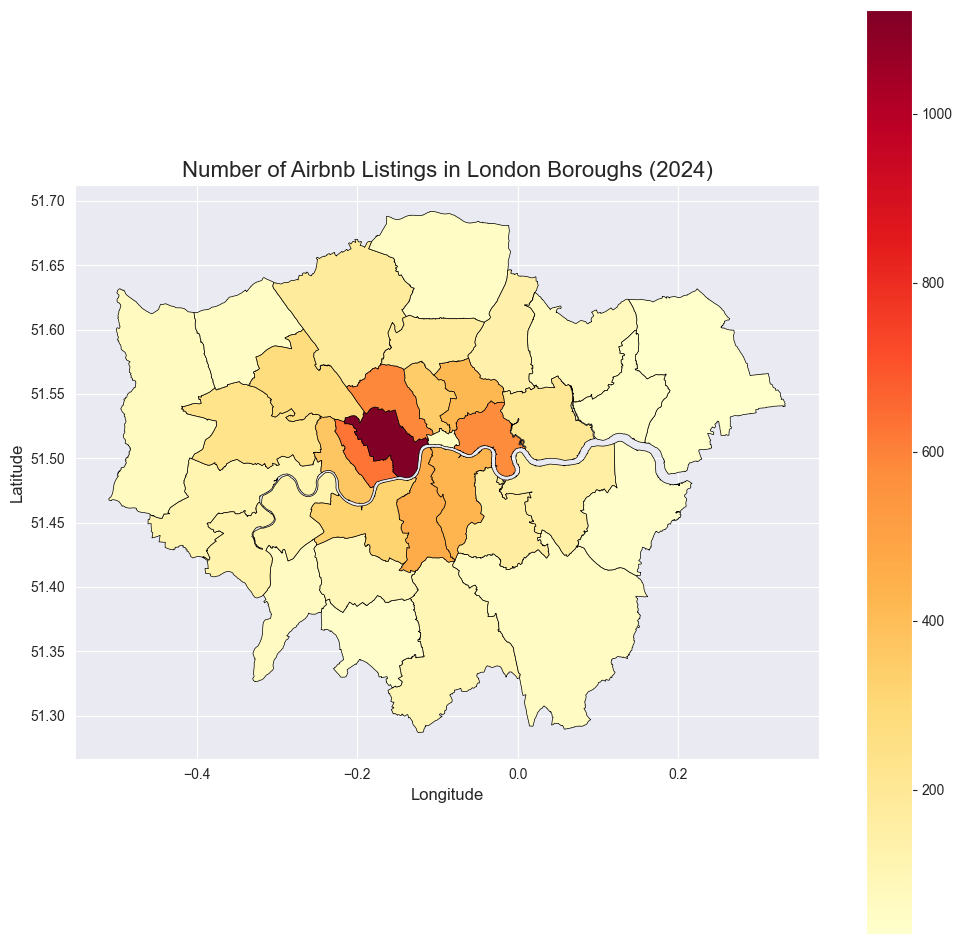

In [49]:
# Ensure boroughs have a CRS set
if boroughs.crs is None:
    boroughs.set_crs(epsg=27700, inplace=True)  # Assuming original CRS is EPSG:27700
boroughs = boroughs.to_crs(epsg=4326)  # Reproject to WGS84 (latitude/longitude)

# Ensure Airbnb data is a GeoDataFrame and set CRS if missing
if filtered_airbnb.crs is None:
    filtered_airbnb = gpd.GeoDataFrame(
        filtered_airbnb,
        geometry=filtered_airbnb.geometry,
        crs="EPSG:27700"  # Assuming original CRS is EPSG:27700
    )
filtered_airbnb = filtered_airbnb.to_crs(epsg=4326)  # Reproject to WGS84

# Perform spatial join to assign each Airbnb to a borough
airbnb_in_boroughs = gpd.sjoin(filtered_airbnb, boroughs, how="inner", predicate="within")

# Count the number of Airbnb listings in each borough
borough_counts = airbnb_in_boroughs.groupby("NAME").size().reset_index(name="Airbnb_Counts")

# Debug: Print borough counts
print(borough_counts.head())

# Merge the counts back with the boroughs GeoDataFrame
boroughs = boroughs.merge(borough_counts, left_on="NAME", right_on="NAME", how="left")

# Debug: Check if the Airbnb_Counts column exists
print(boroughs.columns)

# Fill NaN values with 0 (in case there are boroughs with no Airbnb listings)
boroughs["Airbnb_Counts"] = boroughs["Airbnb_Counts"].fillna(0)

# Plot the choropleth map with the YlOrRd colormap
fig, ax = plt.subplots(figsize=(12, 12))
boroughs.plot(
    column="Airbnb_Counts",
    cmap="YlOrRd",  # Bright red -> orange -> yellow
    legend=True,
    edgecolor="black",
    linewidth=0.5,
    ax=ax
)

# Add title and labels
plt.title("Number of Airbnb Listings in London Boroughs (2024)", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Display the map
plt.show()



# Calculating the Average Price of Airbnb Listings in London Boroughs


                   NAME  Average_Price
0  Barking and Dagenham      87.487805
1                Barnet     118.785714
2                Bexley      74.216216
3                 Brent     120.790614
4               Bromley     113.952381


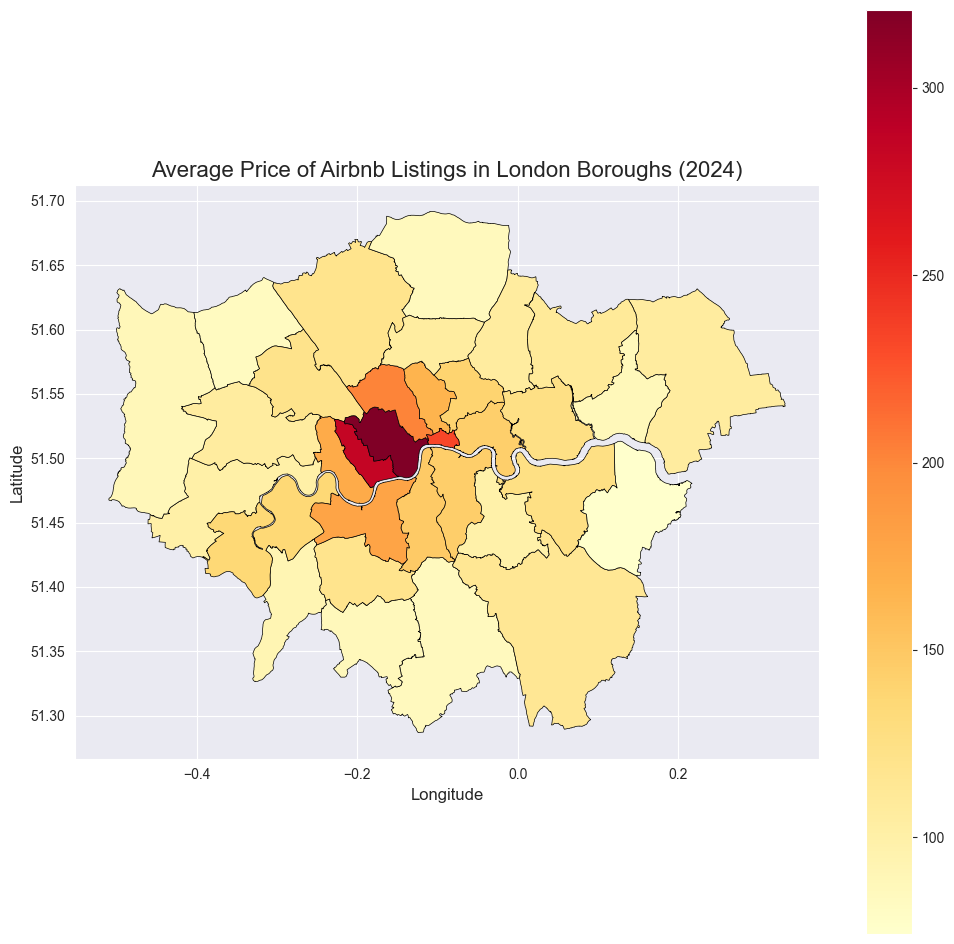

In [50]:
# Calculate the average price of Airbnb listings in each borough
borough_prices = airbnb_in_boroughs.groupby("NAME")["price"].mean().reset_index(name="Average_Price")

# Debug: Print borough prices
print(borough_prices.head())

# Merge the average prices back with the boroughs GeoDataFrame
boroughs = boroughs.merge(borough_prices, left_on="NAME", right_on="NAME", how="left")

# Fill NaN values with 0 (in case there are boroughs with no Airbnb listings)
boroughs["Average_Price"] = boroughs["Average_Price"].fillna(0)

# Plot the choropleth map with the YlOrRd colormap
fig, ax = plt.subplots(figsize=(12, 12))
boroughs.plot(
    column="Average_Price",
    cmap="YlOrRd",  # Bright red -> orange -> yellow
    legend=True,
    edgecolor="black",
    linewidth=0.5,
    ax=ax
)

# Add title and labels
plt.title("Average Price of Airbnb Listings in London Boroughs (2024)", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Display the map
plt.show()

# Types of Listings - Filtered
Filter set to - Entire home/apt

In [52]:
# Filter the data to include only entire home/apartment listings
filtered_airbnb = filtered_airbnb[filtered_airbnb['room_type'] == "Entire home/apt"]

In [53]:
# Print all unique property types in the filtered data
property_types = filtered_airbnb["property_type"].unique()
print("Unique Property Types:")
print(property_types)

Unique Property Types:
['Entire rental unit' 'Entire serviced apartment' 'Entire home'
 'Entire condo' 'Entire guest suite' 'Entire townhouse' 'Entire loft'
 'Entire guesthouse' 'Houseboat' 'Entire cottage' 'Tiny home'
 'Entire villa' 'Entire home/apt' 'Entire vacation home' 'Entire cabin'
 'Boat' 'Entire place' 'Shepherd’s hut' 'Earthen home' 'Entire bungalow'
 'Barn' 'Room in aparthotel']


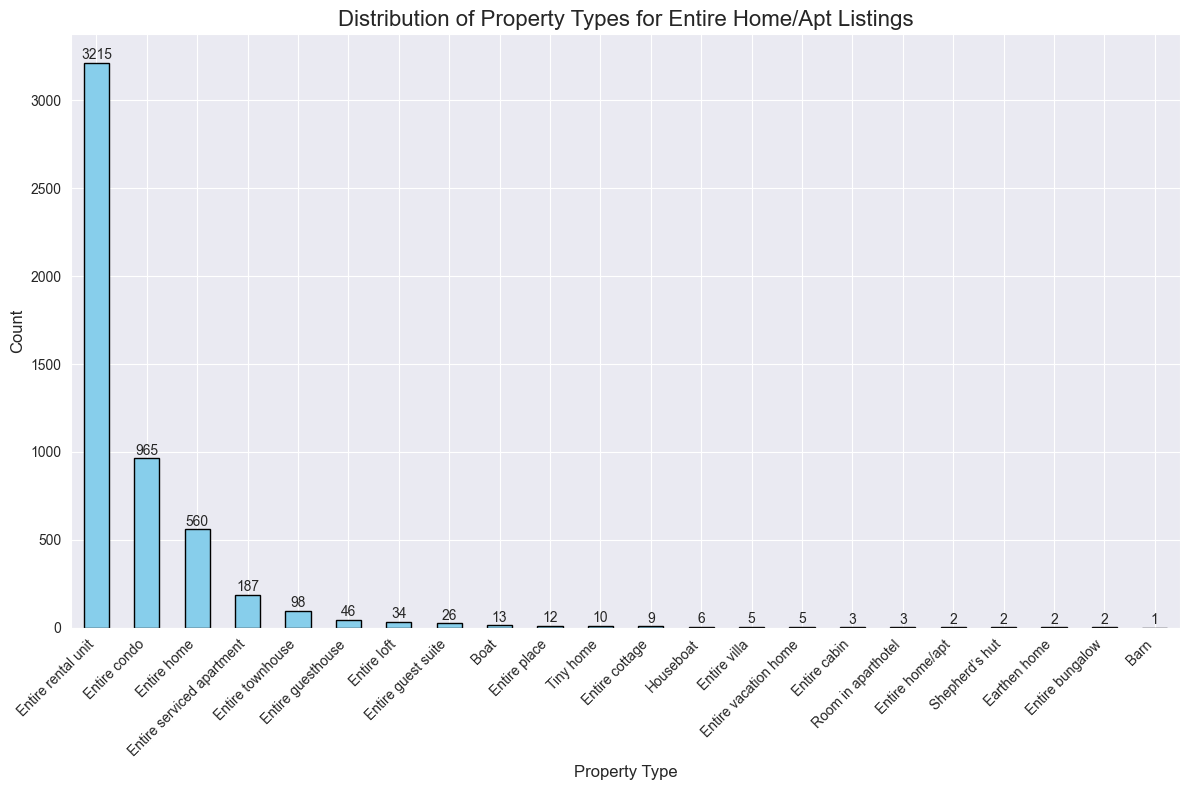

In [56]:
# Create a bar chart
plt.figure(figsize=(12, 8))
bars = property_type_counts.plot(kind="bar", color="skyblue", edgecolor="black")

# Add data labels
for i, value in enumerate(property_type_counts.values):
    plt.text(i, value + 20, str(value), ha="center", fontsize=10)

# Add title and labels
plt.title("Distribution of Property Types for Entire Home/Apt Listings", fontsize=16)
plt.xlabel("Property Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)

# Display the chart
plt.tight_layout()
plt.show()

# Types of Hosts 

Number of Superhosts: 17294
Proportion of Superhosts: 20.86%

Average Number of Listings:
Superhosts: 9.930900890482247
Non-Superhosts: 27.646973646104836


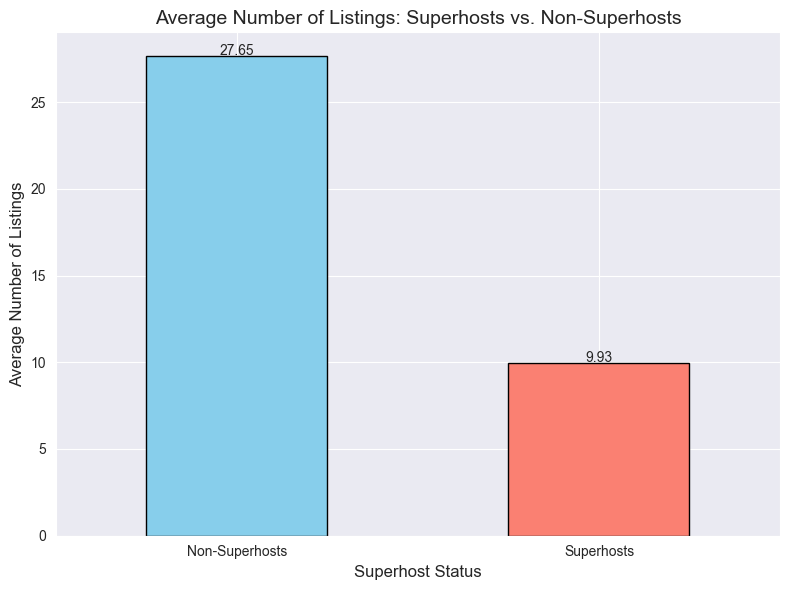

In [57]:
# Convert 'host_is_superhost' to boolean if it isn't already
airbnb['host_is_superhost'] = airbnb['host_is_superhost'].astype(bool)

# 1. Count the number of superhosts and non-superhosts
superhost_counts = airbnb['host_is_superhost'].value_counts()
total_hosts = len(airbnb)
proportion_superhosts = superhost_counts[True] / total_hosts * 100

print("Number of Superhosts:", superhost_counts[True])
print("Proportion of Superhosts: {:.2f}%".format(proportion_superhosts))

# 2. Average number of listings for superhosts vs. non-superhosts
average_listings = airbnb.groupby('host_is_superhost')['host_listings_count'].mean()
print("\nAverage Number of Listings:")
print("Superhosts:", average_listings[True])
print("Non-Superhosts:", average_listings[False])

# 3. Create a bar chart comparing average listings
plt.figure(figsize=(8, 6))
average_listings.plot(kind='bar', color=['skyblue', 'salmon'], edgecolor='black')
plt.title('Average Number of Listings: Superhosts vs. Non-Superhosts', fontsize=14)
plt.xlabel('Superhost Status', fontsize=12)
plt.ylabel('Average Number of Listings', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Non-Superhosts', 'Superhosts'], rotation=0, fontsize=10)

# Add data labels
for i, value in enumerate(average_listings):
    plt.text(i, value + 0.1, f"{value:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Property Distibution by Hosts

<Figure size 1400x600 with 0 Axes>

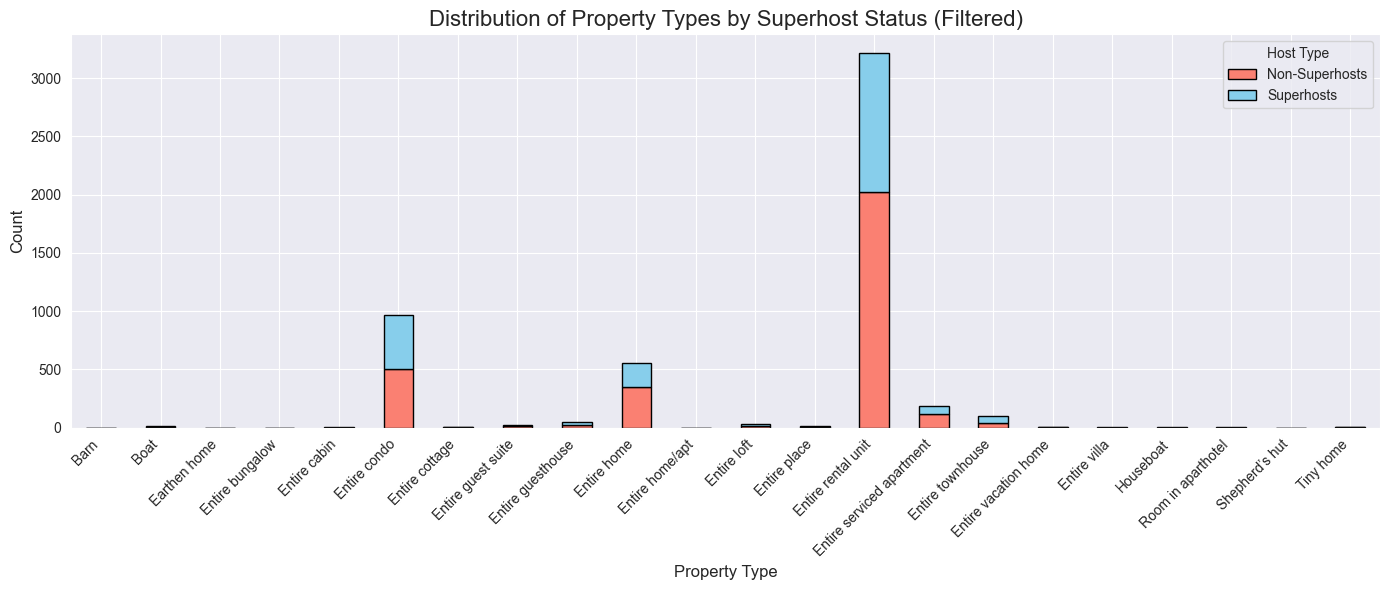

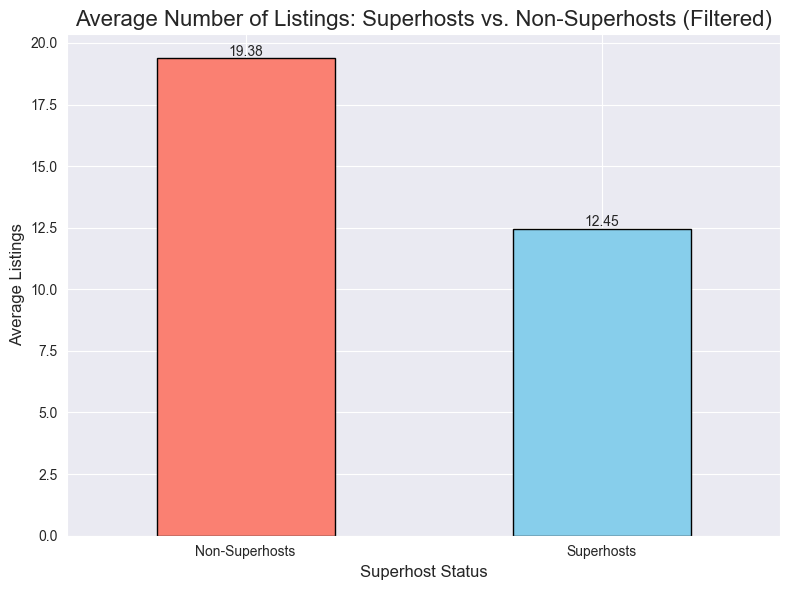

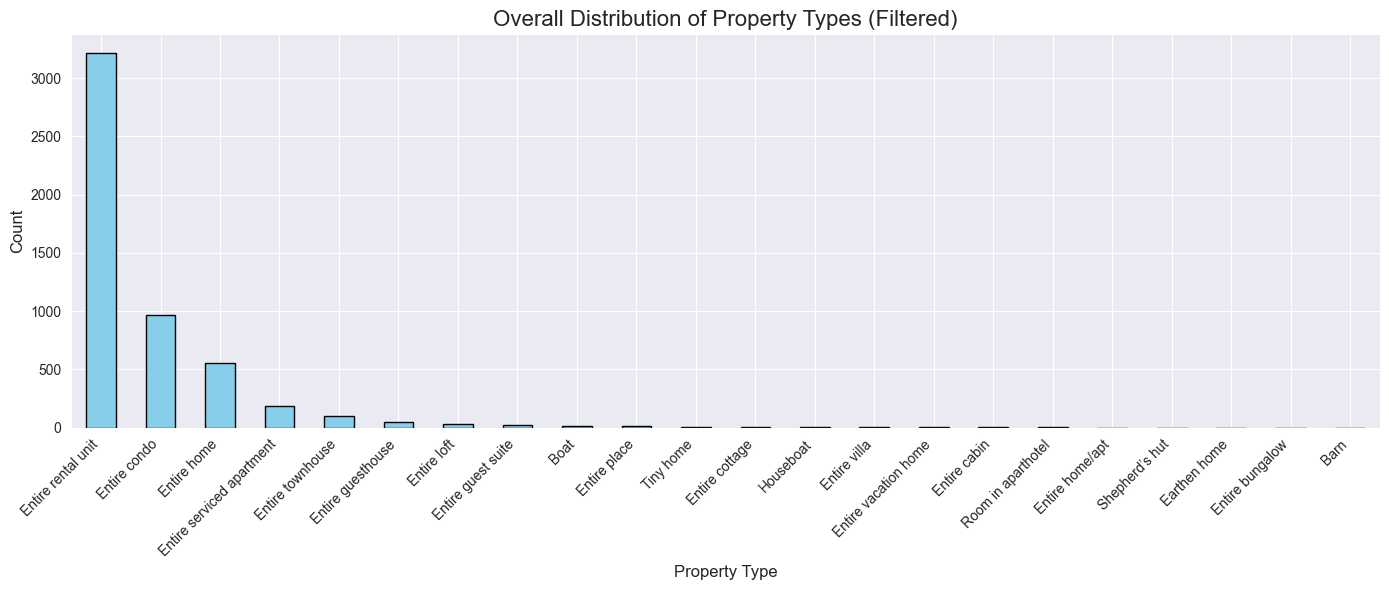

Key Observations (Filtered Data):
- Superhosts in the filtered data tend to list more properties on average than non-superhosts.
- Certain property types dominate the filtered data, such as 'Entire rental unit' and 'Entire serviced apartment'.
- Superhosts are associated with a greater variety of property types compared to non-superhosts.


In [59]:
# 1. Distribution of property types by superhost status (filtered data)
property_type_distribution = filtered_airbnb.groupby(['host_is_superhost', 'property_type']).size().unstack(fill_value=0)

# 2. Average number of listings per host (superhosts vs. non-superhosts) in filtered data
average_listings = filtered_airbnb.groupby('host_is_superhost')['host_listings_count'].mean()

# 3. Total distribution of property types in filtered data
total_property_type_distribution = filtered_airbnb['property_type'].value_counts()

# Plot 1: Distribution of property types by superhost status
plt.figure(figsize=(14, 6))
property_type_distribution.T.plot(kind='bar', stacked=True, figsize=(14, 6), color=['salmon', 'skyblue'], edgecolor='black')
plt.title('Distribution of Property Types by Superhost Status (Filtered)', fontsize=16)
plt.xlabel('Property Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(['Non-Superhosts', 'Superhosts'], title='Host Type', fontsize=10)
plt.tight_layout()
plt.show()

# Plot 2: Average listings for superhosts vs. non-superhosts (filtered data)
plt.figure(figsize=(8, 6))
average_listings.plot(kind='bar', color=['salmon', 'skyblue'], edgecolor='black')
plt.title('Average Number of Listings: Superhosts vs. Non-Superhosts (Filtered)', fontsize=16)
plt.xlabel('Superhost Status', fontsize=12)
plt.ylabel('Average Listings', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Non-Superhosts', 'Superhosts'], rotation=0, fontsize=10)

# Add data labels
for i, value in enumerate(average_listings):
    plt.text(i, value + 0.1, f"{value:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Plot 3: Total distribution of property types in filtered data
plt.figure(figsize=(14, 6))
total_property_type_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Overall Distribution of Property Types (Filtered)', fontsize=16)
plt.xlabel('Property Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

# Print key observations for filtered data
print("Key Observations (Filtered Data):")
print("- Superhosts in the filtered data tend to list more properties on average than non-superhosts.")
print("- Certain property types dominate the filtered data, such as 'Entire rental unit' and 'Entire serviced apartment'.")
print("- Superhosts are associated with a greater variety of property types compared to non-superhosts.")